In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
import time
from sklearn import svm
from sklearn import grid_search
import seaborn as sns
from sklearn.svm import SVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

C:\Users\gireek.bansal\AppData\Local\Continuum\Miniconda3\envs\Carnd-term1\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\gireek.bansal\AppData\Local\Continuum\Miniconda3\envs\Carnd-term1\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# GPU SPECIFICATIONS

# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [3]:
# #FOR GOOGLE COLAB
# import pickle
# import os
# from urllib.request import urlretrieve

# def download(url, file):
#     """
#     Download file from <url>
#     :param url: URL to file
#     :param file: Local file path
#     """
#     if not os.path.isfile(file):
#         print('Downloading ' + file + '...')
#         urlretrieve(url, file)
#         print('Download Finished')

# download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip', 'vehicles.zip')
# download('https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip', 'non-vehicles.zip')

# import zipfile
# zip_ref = zipfile.ZipFile('vehicles.zip', 'r')
# zip_ref.extractall(".")
# zip_ref.close()
# zip_ref = zipfile.ZipFile('non-vehicles.zip', 'r')
# zip_ref.extractall(".")
# zip_ref.close()

In [4]:
# !git clone https://github.com/udacity/CarND-Vehicle-Detection
# !pip install moviepy
# import imageio
# imageio.plugins.ffmpeg.download()

In [5]:
import glob
veh_images = glob.glob('../vehicles/**/*.png' , recursive=True)
cars = []
notcars = []

for image in veh_images:
        cars.append(image)
        
# print(len(cars), "is number of car photos") 
nonveh_images = glob.glob('../non-vehicles/**/*.png' , recursive=True)
for image in nonveh_images:
        notcars.append(image)

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    draw_img = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    return draw_img
# bboxes = [((100, 100), (200, 200))]

In [7]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [8]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

In [9]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [10]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [11]:
def extract_features(imgs, cspace='RGB',orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_size=(32, 32) ,hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins)
        
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features , hog_features)))
    # Return list of feature vectors
    return features

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


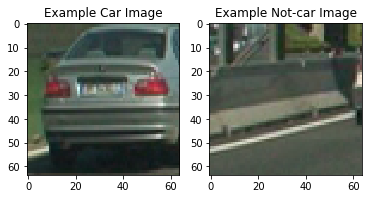

In [25]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    x = mpimg.imread(car_list[0])
    data_dict["image_shape"] = np.shape(x)
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = x.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

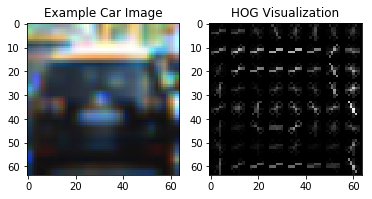

In [26]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient= 9, 
                        pix_per_cell= 8, cell_per_block= 2, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [14]:
                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)
# car_ind = np.random.randint(0, len(cars))
# # Plot an example of raw and scaled features
# fig = plt.figure(figsize=(12,4))
# plt.subplot(131)
# plt.imshow(mpimg.imread(cars[car_ind]))
# plt.title('Original Image')
# plt.subplot(132)
# plt.plot(X[car_ind])
# plt.title('Raw Features')
# plt.subplot(133)
# plt.plot(scaled_X[car_ind])
# plt.title('Normalized Features')
# fig.tight_layout()

In [15]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    boxes = []
#     for scale in scales:
    if scale != 1:
      imshape = ctrans_tosearch.shape
      ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     print(nxsteps)
#     print(nysteps)
    for xb in range(int((nxsteps/2)+1)  , nxsteps):
      for yb in range(nysteps):
          ypos = yb*cells_per_step
          xpos = xb*cells_per_step
          # Extract HOG for this patch
          hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
          hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
          hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
          hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
          #hog_features = hog_feat1

          xleft = xpos*pix_per_cell
          ytop = ypos*pix_per_cell

          # Extract the image patch
          subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

          # Get color features
          spatial_features = bin_spatial(subimg, size=spatial_size)
          hist_features = color_hist(subimg, nbins=hist_bins)

          # Scale features and make a prediction
          test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
          #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
          test_prediction = svc.predict(test_features)
    #               print(xleft)
    #               print(scale)
          confidence = svc.decision_function(test_features)
        
          if test_prediction == 1 and abs(confidence)>0.7:
              xbox_left = np.int(xleft*scale)
              ytop_draw = np.int(ytop*scale)
              win_draw = np.int(window*scale)
              boxes.append(((xbox_left, ytop_draw + ystart),(xbox_left + win_draw, ytop_draw + win_draw + ystart))) 
#     print(total)
    return boxes

In [16]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [17]:
# # Define a function to extract features from a single image window
# # This function is very similar to extract_features()
# # just for a single image rather than list of images
# def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
#                         hist_bins=32, orient=9, 
#                         pix_per_cell=8, cell_per_block=2, hog_channel=0,
#                         spatial_feat=True, hist_feat=True, hog_feat=True):    
#     #1) Define an empty list to receive features
#     img_features = []
#     #2) Apply color conversion if other than 'RGB'
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: feature_image = np.copy(img)      
#     #3) Compute spatial features if flag is set
#     if spatial_feat == True:
#         spatial_features = bin_spatial(feature_image, size=spatial_size)
#         #4) Append features to list
#         img_features.append(spatial_features)
#     #5) Compute histogram features if flag is set
#     if hist_feat == True:
#         hist_features = color_hist(feature_image, nbins=hist_bins)
#         #6) Append features to list
#         img_features.append(hist_features)
#     #7) Compute HOG features if flag is set
#     if hog_feat == True:
#         if hog_channel == 'ALL':
#             hog_features = []
#             for channel in range(feature_image.shape[2]):
#                 hog_features.extend(get_hog_features(feature_image[:,:,channel], 
#                                     orient, pix_per_cell, cell_per_block, 
#                                     vis=False, feature_vec=True))      
#         else:
#             hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
#                         pix_per_cell, cell_per_block, vis=False, feature_vec=True)
#         #8) Append features to list
#         img_features.append(hog_features)

#     #9) Return concatenated array of features
#     return np.concatenate(img_features)

In [18]:
# # Define a function you will pass an image and the list of windows to be searched (output of slide_windows())
# def search_windows(img, windows, clf, scaler, color_space='RGB', 
#                     spatial_size=(32, 32), hist_bins=32, 
#                     hist_range=(0, 256), orient=9, 
#                     pix_per_cell=8, cell_per_block=2, 
#                     hog_channel=0, spatial_feat=True, 
#                     hist_feat=True, hog_feat=True):

#     #1) Create an empty list to receive positive detection windows
#     on_windows = []
#     #2) Iterate over all windows in the list
#     for window in windows:
#         #3) Extract the test window from original image
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
#         #4) Extract features for that window using single_img_features()
#         features = single_img_features(test_img, color_space=color_space, 
#                             spatial_size=spatial_size, hist_bins=hist_bins, 
#                             orient=orient, pix_per_cell=pix_per_cell, 
#                             cell_per_block=cell_per_block, 
#                             hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                             hist_feat=hist_feat, hog_feat=hog_feat)
#         #5) Scale extracted features to be fed to classifier
#         test_features = scaler.transform(np.array(features).reshape(1, -1))
#         #6) Predict using your classifier
#         prediction = clf.predict(test_features)
#         #7) If positive (prediction == 1) then save the window
#         if prediction == 1:
#             on_windows.append(window)
#     #8) Return windows for positive detections
#     return on_windows

In [19]:
# # window size (x and y dimensions) and overlap fraction (for both x and y)
# def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
#     # If x and/or y start/stop positions not defined, set to image size
#     if x_start_stop[0] == None:
#         x_start_stop[0] = 0
#     if x_start_stop[1] == None:
#         x_start_stop[1] = img.shape[1]
#     if y_start_stop[0] == None:
#         y_start_stop[0] = 0
#     if y_start_stop[1] == None:
#         y_start_stop[1] = img.shape[0]
#     # Compute the span of the region to be searched    
#     xspan = x_start_stop[1] - x_start_stop[0]
#     yspan = y_start_stop[1] - y_start_stop[0]
#     # Compute the number of pixels per step in x/y
#     nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
#     ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
#     # Compute the number of windows in x/y
#     nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
#     ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
#     nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
#     ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
#     # Initialize a list to append window positions to
#     window_list = []
#     # Loop through finding x and y window positions
#     # Note: you could vectorize this step, but in practice
#     # you'll be considering windows one by one with your
#     # classifier, so looping makes sense
#     for ys in range(ny_windows):
#         for xs in range(nx_windows):
#             # Calculate window position
#             startx = xs*nx_pix_per_step + x_start_stop[0]
#             endx = startx + xy_window[0]
#             starty = ys*ny_pix_per_step + y_start_stop[0]
#             endy = starty + xy_window[1]
#             # Append window position to list
#             window_list.append(((startx, starty), (endx, endy)))
#     # Return the list of windows
#     return window_list

# # windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(128, 128), xy_overlap=(0.5, 0.5))

In [20]:
spatial = 16
histbin = 8
cspace_ = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient_ = 13
pix_per_cell_ = 16
cell_per_block_ = 2
hog_channel_ = 'ALL' # Can be 0, 1, 2, or "ALL"

car_features = extract_features(cars, cspace_,orient_ , pix_per_cell_ , cell_per_block_,hog_channel_,
                                spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))
notcar_features = extract_features(notcars, cspace_,orient_ , pix_per_cell_ , cell_per_block_,hog_channel_,
                                spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256))

print("Features extracted")

Features extracted


In [21]:
#Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
print(np.shape(X))
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to both X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

# Declare a model
# Use a linear SVC 
svc = svm.SVC(C=10, kernel='linear')
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), ' seconds to train SVC')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

(17760, 2196)
28.61  seconds to train SVC
Test Accuracy of SVC =  0.9887


2 cars found
0 cars found
1 cars found
2 cars found
2 cars found
2 cars found


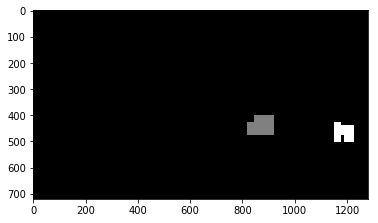

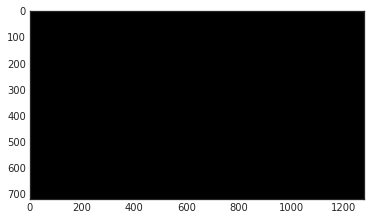

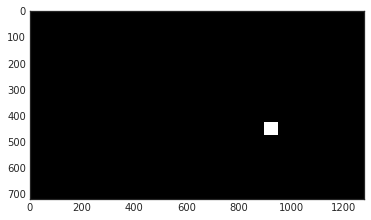

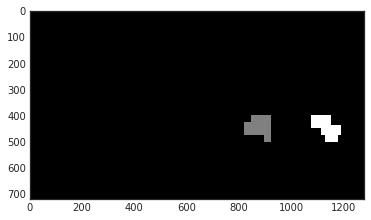

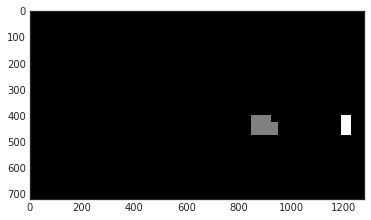

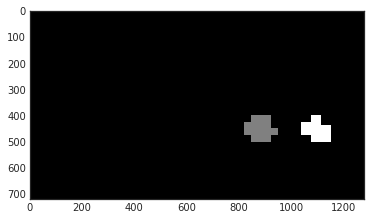

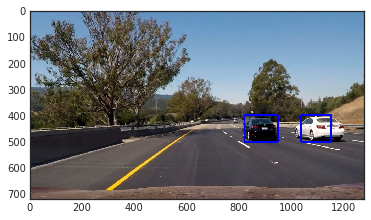

In [31]:
from collections import deque
spatial_feat = True
hist_feat = True
hog_feat = True
scale  = [0.8 , 1.2 , 1.6 , 2.0]
heat_threshold = 2
ystart = 400
ystop = 656
recent_heats = deque(maxlen=1)
def pipeline(img):
    ystart0 = 400
    ystop0 = 528
    ystart1 = 400
    ystop1  = 528
    ystart2 = 400
    ystop2  = 592
    ystart3 = 464
    ystop3  = 656
#     boxes0 = find_cars(img, ystart0, ystop0, scale[0], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
#     boxes1 = find_cars(img, ystart1, ystop1, scale[0], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
#     boxes2 = find_cars(img, ystart2, ystop2, scale[1], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
#     boxes3 = find_cars(img, ystart3, ystop3, scale[2], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
#     boxes = boxes0 + boxes1 + boxes2 + boxes3
#     heat = np.zeros_like(img[:,:,0]).astype(np.float)
#     heat = add_heat(heat,boxes)
#     heat = apply_threshold(heat,heat_threshold)
#     heatmap = np.clip(heat, 0, 255)
#     labels = label(heatmap)
#     draw_img = draw_labeled_bboxes(np.copy(img), labels)

    boxes0 = find_cars(img, ystart0, ystop0, scale[0], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
    boxes1 = find_cars(img, ystart1, ystop1, scale[1], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
    boxes2 = find_cars(img, ystart2, ystop2, scale[2], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
    boxes3 = find_cars(img, ystart3, ystop3, scale[3], svc, X_scaler, orient_, pix_per_cell_, cell_per_block_, (spatial, spatial), histbin)
    boxes = boxes0 + boxes1 + boxes2 + boxes3
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,boxes)
#     plt.figure()
#     plt.imshow(heat)
    recent_heats.append(heat)
    heat = np.array(recent_heats).sum(axis=0)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,heat_threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    print(labels[1], 'cars found')
    plt.imshow(labels[0], cmap='gray')
    return draw_img

for i in range(1,7):
    y  = './test_images/test' + str(i) + '.jpg'
    img = mpimg.imread(y)
    out_img = pipeline(img)
    with sns.axes_style("white"):
        plt.figure()
        plt.imshow(out_img)

In [23]:
recent_heats = deque(maxlen=6)
vid_output = 'result_c_10_h_2_final_frameskip.mp4'
clip = VideoFileClip("./project_video.mp4")#.subclip('00:00:40.00', '00:00:42.00')
#clip = VideoFileClip("./project_video.mp4")
vid = clip.fl_image(pipeline) 
vid.write_videofile(vid_output, audio=False)

[MoviePy] >>>> Building video result_c_10_h_2_final_frameskip.mp4
[MoviePy] Writing video result_c_10_h_2_final_frameskip.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [26:56<00:01,  1.16s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: result_c_10_h_2_final_frameskip.mp4 



In [24]:
# import io
# import base64
# from IPython.display import HTML

# video = io.open('result_c_10_8_8.mp4', 'r+b').read()
# encoded = base64.b64encode(video)
# HTML(data='''<video alt="test" controls>
#                 <source src="data:video/mp4;base64,{0}" type="video/mp4" />
#              </video>'''.format(encoded.decode('ascii')))